# MVP Monte Carlo Draft Simulator

Minimal, easy-to-run Monte-Carlo draft simulator for quick insight during a draft.
Uses 80% ESPN + 20% ADP weighting for pick probabilities and simulates remainder of draft.

**Key Features:**
- Estimates availability probabilities
- Calculates expected roster value (EV) per candidate pick
- Supports existing roster (for mid-draft decisions)
- Simple visuals you can tweak in Jupyter

In [ ]:
# Cell 1: Imports & Config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# CONFIG: Tweak these for your draft
CONFIG = {
    'n_teams': 14,
    'rounds': 15,
    'my_team_idx': 7,          # 0-based index of your team (8th pick = index 7)
    'current_global_pick': 0,   # 0-based global pick index in draft order
    'top_k': 150,              # how many players to consider in pool
    'candidate_count': 10,     # how many candidates to evaluate
    'n_sims': 10,            # number of Monte-Carlo simulations (increase for accuracy)
    'espn_weight': 0.8,        # ESPN ranking weight
    'adp_weight': 0.2,         # ADP ranking weight
    'use_crn': True,           # use common random seeds for fair comparison
    # List of player names already on your roster (update during draft)
    'my_current_roster': [],  # e.g. ["Ja'Marr Chase", "Bijan Robinson"]
}

print(f"Configuration loaded: Team #{CONFIG['my_team_idx']+1} (pick {CONFIG['my_team_idx']+1})")

Configuration loaded: Team #8 (pick 8)


In [2]:
# Cell 2: Helper Functions

def get_pick_order(n_teams, rounds):
    """Generate snake draft pick order"""
    order = []
    for r in range(rounds):
        if r % 2 == 0:
            order.extend(range(n_teams))
        else:
            order.extend(reversed(range(n_teams)))
    return np.array(order, dtype=np.int32)

def softmax(x, tau=5.0):
    """Convert to probabilities with temperature control"""
    e = np.exp((x - np.max(x)) / tau)
    return e / e.sum()

def rank_to_score(rank_array):
    """Convert rank (1=best) to score (higher=better)"""
    return 1.0 / (np.array(rank_array, dtype=float) + 1e-6)

# Generate pick order
PICK_ORDER = get_pick_order(CONFIG['n_teams'], CONFIG['rounds'])
TOTAL_PICKS = len(PICK_ORDER)

# Starter requirements for roster optimization
STARTER_REQUIREMENTS = {
    'QB': 1,
    'RB': 2,
    'WR': 3,
    'TE': 1,
    'FLEX': 1,  # Best remaining RB/WR/TE
    'K': 1,
    'DST': 1
}

print(f"Draft structure: {CONFIG['n_teams']} teams, {CONFIG['rounds']} rounds = {TOTAL_PICKS} picks")

Draft structure: 12 teams, 15 rounds = 180 picks


In [3]:
# Cell 3: Load Real Data

def load_player_data():
    """Load and merge ESPN rankings, ADP data, and projections"""
    
    # Load ESPN rankings
    espn_df = pd.read_csv('../data/espn_projections_20250814.csv')
    espn_df['espn_rank'] = espn_df['overall_rank']
    
    # Load ADP data
    adp_df = pd.read_csv('../data/fantasypros_adp_20250815.csv')
    adp_df['adp_rank'] = adp_df['RANK']
    adp_df['player_name'] = adp_df['PLAYER']
    
    # Load projections (for fantasy points)
    proj_df = pd.read_csv('../data/projections/projections_all_positions_20250814.csv')
    proj_df['player_name'] = proj_df['PLAYER'].fillna(proj_df['UNNAMED:_0_LEVEL_0_PLAYER'])
    proj_df['proj'] = proj_df['MISC_FPTS'].fillna(proj_df['FPTS']).fillna(100)  # Default projection
    
    # Merge on player name
    merged = espn_df[['player_name', 'position', 'espn_rank', 'team']].merge(
        adp_df[['player_name', 'adp_rank']], 
        on='player_name', 
        how='outer'
    )
    
    merged = merged.merge(
        proj_df[['player_name', 'proj', 'POSITION']], 
        on='player_name', 
        how='left'
    )
    
    # Clean up positions
    merged['pos'] = merged['position'].fillna(merged['POSITION']).fillna('FLEX')
    merged['pos'] = merged['pos'].str.extract(r'([A-Z]+)')[0]  # Extract position code
    
    # Fill missing ranks with worst-case
    merged['espn_rank'] = merged['espn_rank'].fillna(300)
    merged['adp_rank'] = merged['adp_rank'].fillna(300)
    merged['proj'] = merged['proj'].fillna(50)
    
    # Create unique player_id
    merged['player_id'] = range(len(merged))
    
    # Clean and prepare final dataframe
    players_df = merged[['player_id', 'player_name', 'pos', 'proj', 'espn_rank', 'adp_rank']].copy()
    players_df.columns = ['player_id', 'name', 'pos', 'proj', 'espn_rank', 'adp_rank']
    players_df = players_df.dropna(subset=['name'])
    players_df = players_df.set_index('player_id')
    
    return players_df

# Load the data
players_df = load_player_data()
print(f"Loaded {len(players_df)} players")
print(f"Positions: {players_df['pos'].value_counts().to_dict()}")
players_df.head()

Loaded 396 players
Positions: {'WR': 104, 'RB': 90, 'FLEX': 65, 'DST': 53, 'TE': 34, 'QB': 32, 'K': 18}


,name,pos,proj,espn_rank,adp_rank
player_id,,,,,
0,49ers D/ST,DST,50.0,298.0,300.0
1,A.J. Brown,WR,50.0,15.0,20.0
2,A.J. Dillon,FLEX,50.0,300.0,277.0
3,Aaron Jones,RB,50.0,71.0,300.0
4,Aaron Jones Sr.,FLEX,50.0,300.0,64.0


In [4]:
# Cell 4: Prepare Player Pool

# Calculate combined scores
players_df['espn_score'] = rank_to_score(players_df['espn_rank'])
players_df['adp_score'] = rank_to_score(players_df['adp_rank'])
players_df['base_score'] = (
    CONFIG['espn_weight'] * players_df['espn_score'] + 
    CONFIG['adp_weight'] * players_df['adp_score']
)

# Select top_k players by ESPN rank
topk_df = players_df.nsmallest(CONFIG['top_k'], 'espn_rank')

# Get available players (exclude already drafted)
available_ids = topk_df.index.to_numpy()
if len(CONFIG['my_current_roster']) > 0:
    # Filter out players already on roster
    roster_mask = topk_df['name'].isin(CONFIG['my_current_roster'])
    available_ids = topk_df[~roster_mask].index.to_numpy()

print(f"Player pool: {len(available_ids)} available players")
print(f"Top 10 available by projection:")
top_by_proj = players_df.loc[available_ids].nlargest(10, 'proj')[['name', 'pos', 'proj', 'espn_rank', 'adp_rank']]
print(top_by_proj)

Player pool: 150 available players
Top 10 available by projection:
                          name pos  proj  espn_rank  adp_rank
player_id                                                    
159              Ja'Marr Chase  WR  50.0        1.0       1.0
28              Bijan Robinson  RB  50.0        2.0       2.0
223           Justin Jefferson  WR  50.0        3.0       5.0
329             Saquon Barkley  RB  50.0        4.0       3.0
164               Jahmyr Gibbs  RB  50.0        5.0       4.0
62                 CeeDee Lamb  WR  50.0        6.0       6.0
76         Christian McCaffrey  RB  50.0        7.0      11.0
303                 Puka Nacua  WR  50.0        8.0       7.0
259               Malik Nabers  WR  50.0        9.0       8.0
13           Amon-Ra St. Brown  WR  50.0       10.0       9.0


In [5]:
# Cell 5: Team Value Function

def compute_team_value(chosen_ids, players_df):
    """Calculate total fantasy points from optimal starting lineup"""
    if len(chosen_ids) == 0:
        return 0.0
    
    df = players_df.loc[chosen_ids]
    bypos = {
        p: df[df['pos'] == p].sort_values('proj', ascending=False) 
        for p in ['QB', 'RB', 'WR', 'TE', 'K', 'DST']
    }
    
    total = 0.0
    
    # QB x1
    if len(bypos['QB']) > 0:
        total += float(bypos['QB'].iloc[0]['proj'])
    
    # RB x2
    for i in range(min(2, len(bypos['RB']))):
        total += float(bypos['RB'].iloc[i]['proj'])
    
    # WR x3
    for i in range(min(3, len(bypos['WR']))):
        total += float(bypos['WR'].iloc[i]['proj'])
    
    # TE x1
    if len(bypos['TE']) > 0:
        total += float(bypos['TE'].iloc[0]['proj'])
    
    # FLEX: best remaining RB/WR/TE
    flex_pool = []
    flex_pool += list(bypos['RB'].iloc[2:]['proj']) if len(bypos['RB']) > 2 else []
    flex_pool += list(bypos['WR'].iloc[3:]['proj']) if len(bypos['WR']) > 3 else []
    flex_pool += list(bypos['TE'].iloc[1:]['proj']) if len(bypos['TE']) > 1 else []
    if len(flex_pool) > 0:
        total += float(max(flex_pool))
    
    # K x1
    if len(bypos['K']) > 0:
        total += float(bypos['K'].iloc[0]['proj'])
    
    # DST x1
    if len(bypos['DST']) > 0:
        total += float(bypos['DST'].iloc[0]['proj'])
    
    return total

# Test with empty roster
print(f"Empty roster value: {compute_team_value([], players_df):.1f}")

Empty roster value: 0.0


In [6]:
# Cell 6: Pick Probability Function

def build_pick_probs(avail_ids, players_df):
    """Build pick probabilities using 80/20 ESPN/ADP weighting"""
    if len(avail_ids) == 0:
        return np.array([])
    
    scores = players_df.loc[avail_ids]['base_score'].values
    
    # Add small random noise to break ties
    scores = scores + np.random.uniform(0, 0.0001, len(scores))
    
    # Normalize to probabilities
    probs = scores / scores.sum()
    return probs

In [7]:
# Cell 7: Core Monte Carlo Simulation

def simulate_with_candidate(state_pick_index, candidate_id, players_df, avail_ids, 
                           n_sims=500, my_team_idx=0, use_crn=True):
    """
    Simulate drafting a candidate and the remainder of the draft.
    Returns expected value (EV) and availability probabilities.
    """
    # Set up random seeds for reproducibility
    rng_master = np.random.SeedSequence(12345 if use_crn else None)
    seeds = rng_master.spawn(n_sims)
    
    evs = []
    availability_count = defaultdict(int)
    
    # Determine future pick positions for my team
    pick_order = PICK_ORDER
    my_positions = np.where(pick_order == my_team_idx)[0]
    future_my_positions = my_positions[my_positions > state_pick_index]
    
    # Get starting roster from config
    starting_roster_names = CONFIG['my_current_roster'] if len(CONFIG['my_current_roster']) > 0 else []
    starting_roster_ids = []
    if starting_roster_names:
        for name in starting_roster_names:
            matching = players_df[players_df['name'] == name]
            if len(matching) > 0:
                starting_roster_ids.append(matching.index[0])
    
    for sim_i in range(n_sims):
        rng = np.random.default_rng(seeds[sim_i])
        
        # Copy available pool
        pool = list(avail_ids.copy())
        
        # Remove already drafted players
        for p in starting_roster_ids:
            if p in pool:
                pool.remove(p)
        if candidate_id in pool:
            pool.remove(candidate_id)
        
        # Start with existing roster + candidate
        my_chosen = starting_roster_ids.copy()
        my_chosen.append(candidate_id)
        
        # Simulate remaining picks
        for pick_idx in range(state_pick_index + 1, min(TOTAL_PICKS, state_pick_index + 100)):
            if len(pool) == 0:
                break
            
            team = PICK_ORDER[pick_idx]
            
            if team == my_team_idx:
                # My pick: choose greedily by projection
                best = max(pool, key=lambda pid: players_df.loc[pid]['proj'])
                my_chosen.append(best)
                pool.remove(best)
            else:
                # Other team: sample based on probabilities
                probs = build_pick_probs(np.array(pool), players_df)
                if len(probs) > 0 and probs.sum() > 0:
                    chosen = rng.choice(pool, p=probs)
                    pool.remove(chosen)
        
        # Calculate team value
        ev = compute_team_value(my_chosen, players_df)
        evs.append(ev)
        
        # Track availability
        for pid in avail_ids:
            if pid in pool:
                availability_count[pid] += 1
    
    evs = np.array(evs)
    availability_prob = {pid: availability_count[pid] / n_sims for pid in avail_ids}
    
    return evs.mean(), evs.std(), availability_prob

print("Monte Carlo simulator ready")

Monte Carlo simulator ready


In [8]:
# Cell 8: Evaluate Top Candidates

def evaluate_top_candidates(state_pick_index, players_df, avail_ids, 
                           candidate_count=10, n_sims=500):
    """Evaluate the top candidates and return results dataframe"""
    
    # Select top candidates by projection
    candidates = sorted(list(avail_ids), 
                       key=lambda pid: players_df.loc[pid]['proj'], 
                       reverse=True)[:candidate_count]
    
    results = []
    print(f"Evaluating {len(candidates)} candidates with {n_sims} simulations each...")
    
    for i, c in enumerate(candidates):
        mean_ev, sd_ev, avail_prob = simulate_with_candidate(
            state_pick_index, c, players_df, avail_ids, 
            n_sims=n_sims, 
            my_team_idx=CONFIG['my_team_idx'], 
            use_crn=CONFIG['use_crn']
        )
        
        results.append({
            'player_id': c,
            'name': players_df.loc[c]['name'],
            'pos': players_df.loc[c]['pos'],
            'proj': players_df.loc[c]['proj'],
            'espn_rank': players_df.loc[c]['espn_rank'],
            'adp_rank': players_df.loc[c]['adp_rank'],
            'ev': mean_ev,
            'sd': sd_ev,
            'marginal_value': mean_ev  # Will be updated if roster exists
        })
        
        if (i + 1) % 5 == 0:
            print(f"  Processed {i+1}/{len(candidates)} candidates...")
    
    return pd.DataFrame(results).sort_values('ev', ascending=False).reset_index(drop=True)

# Run evaluation
print(f"\nStarting Monte Carlo evaluation at pick #{CONFIG['current_global_pick']+1}")
print(f"Your team: #{CONFIG['my_team_idx']+1}")
print(f"Current roster: {CONFIG['my_current_roster'] if CONFIG['my_current_roster'] else 'Empty'}\n")

res_df = evaluate_top_candidates(
    CONFIG['current_global_pick'], 
    players_df, 
    available_ids,
    candidate_count=CONFIG['candidate_count'], 
    n_sims=CONFIG['n_sims']
)

print("\n✅ Evaluation complete!")


Starting Monte Carlo evaluation at pick #1
Your team: #8
Current roster: Empty

Evaluating 10 candidates with 500 simulations each...
  Processed 5/10 candidates...
  Processed 10/10 candidates...

✅ Evaluation complete!


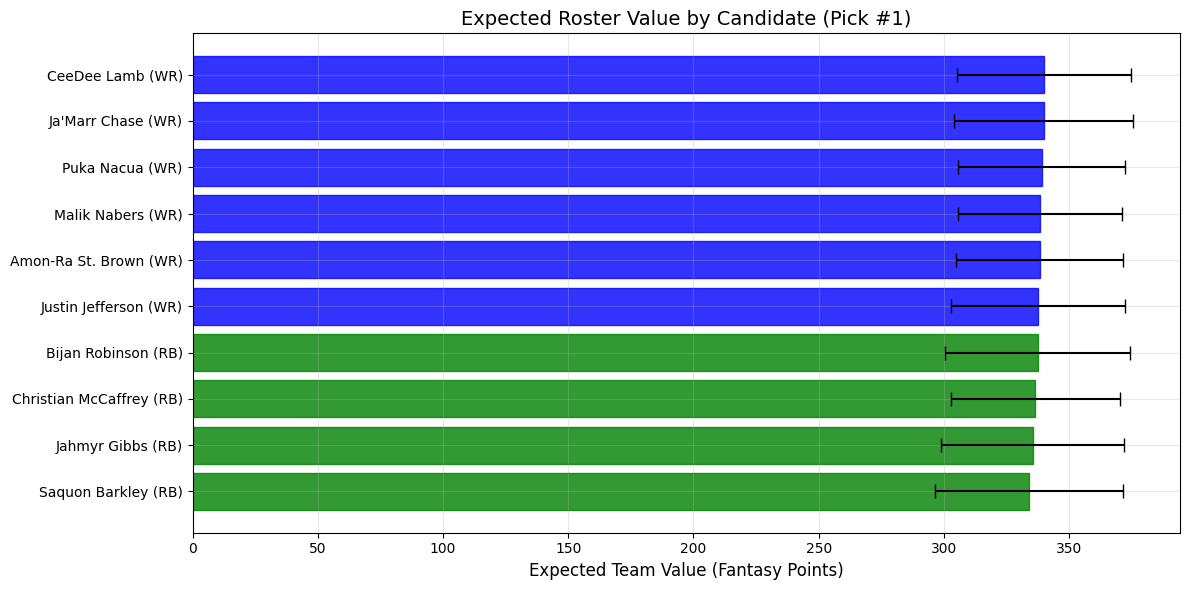


📊 Top 5 Candidates by Expected Value:
                name pos  proj  espn_rank  adp_rank     ev         sd
0        CeeDee Lamb  WR  50.0        6.0       6.0  339.9  34.828006
1      Ja'Marr Chase  WR  50.0        1.0       1.0  339.8  35.720582
2         Puka Nacua  WR  50.0        8.0       7.0  339.1  33.259435
3       Malik Nabers  WR  50.0        9.0       8.0  338.4  32.793902
4  Amon-Ra St. Brown  WR  50.0       10.0       9.0  338.2  33.477754


In [9]:
# Cell 9: Visualization - Expected Value Bar Chart

plt.figure(figsize=(12, 6))

# Create labels with position
labels = [f"{row['name']} ({row['pos']})" for _, row in res_df.iterrows()]

# Plot horizontal bars with error bars
bars = plt.barh(labels, res_df['ev'], xerr=res_df['sd'], 
                color='steelblue', alpha=0.8, capsize=5)

# Color bars by position
pos_colors = {'QB': 'red', 'RB': 'green', 'WR': 'blue', 'TE': 'orange', 'K': 'purple', 'DST': 'brown'}
for bar, pos in zip(bars, res_df['pos']):
    bar.set_color(pos_colors.get(pos, 'gray'))

plt.gca().invert_yaxis()
plt.xlabel('Expected Team Value (Fantasy Points)', fontsize=12)
plt.title(f'Expected Roster Value by Candidate (Pick #{CONFIG["current_global_pick"]+1})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 5
print("\n📊 Top 5 Candidates by Expected Value:")
print(res_df[['name', 'pos', 'proj', 'espn_rank', 'adp_rank', 'ev', 'sd']].head())

Computing availability probabilities...


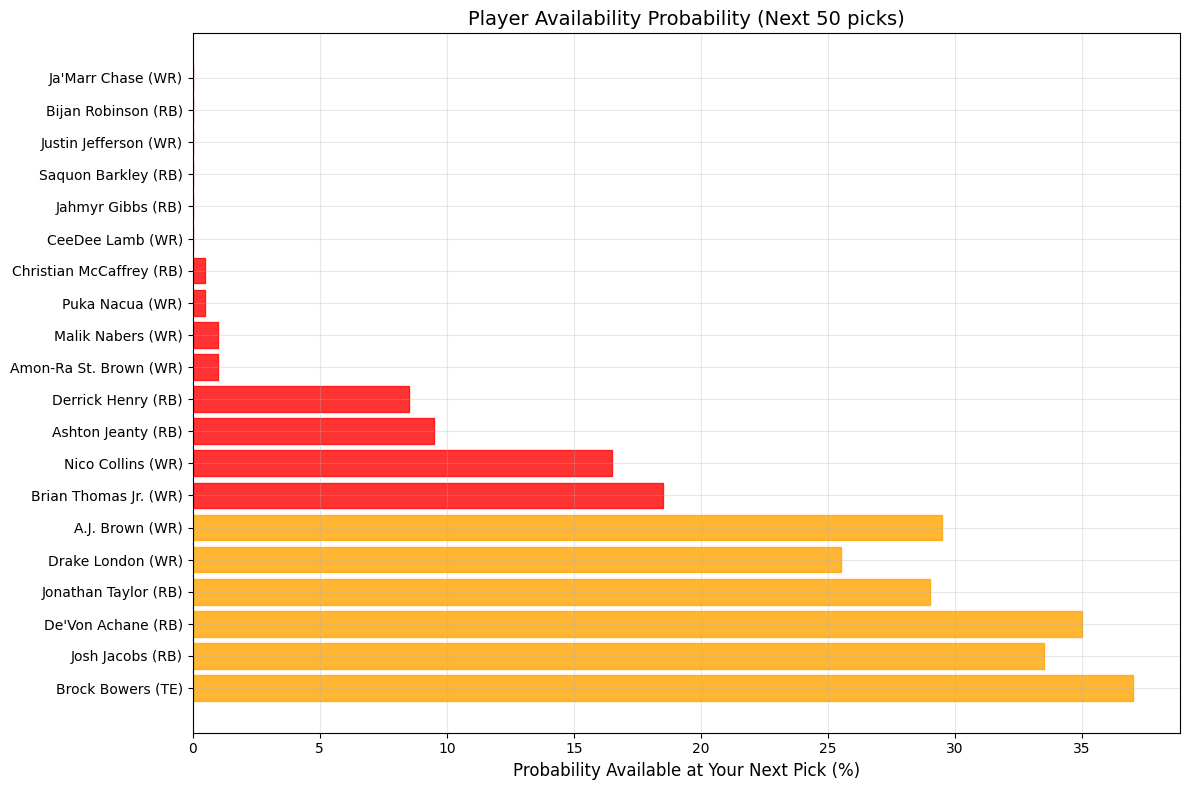


🎯 Color Key:
  🟢 Green: >80% (Very likely available)
  🟡 Yellow: 50-80% (Likely available)
  🟠 Orange: 20-50% (Risky)
  🔴 Red: <20% (Unlikely to be available)


In [10]:
# Cell 10: Availability Heatmap

def compute_baseline_availability(state_pick_index, players_df, avail_ids, n_sims=200):
    """Compute availability without drafting any specific candidate"""
    rng_master = np.random.SeedSequence(999)
    seeds = rng_master.spawn(n_sims)
    availability_count = defaultdict(int)
    
    # Get starting roster
    starting_roster_names = CONFIG['my_current_roster'] if len(CONFIG['my_current_roster']) > 0 else []
    starting_roster_ids = []
    if starting_roster_names:
        for name in starting_roster_names:
            matching = players_df[players_df['name'] == name]
            if len(matching) > 0:
                starting_roster_ids.append(matching.index[0])
    
    for sim_i in range(n_sims):
        rng = np.random.default_rng(seeds[sim_i])
        pool = list(avail_ids.copy())
        
        # Remove roster players
        for p in starting_roster_ids:
            if p in pool:
                pool.remove(p)
        
        # Simulate picks
        for pick_idx in range(state_pick_index + 1, min(TOTAL_PICKS, state_pick_index + 50)):
            if len(pool) == 0:
                break
            
            team = PICK_ORDER[pick_idx]
            if team == CONFIG['my_team_idx']:
                # Greedy pick
                best = max(pool, key=lambda pid: players_df.loc[pid]['proj'])
                pool.remove(best)
            else:
                # Probabilistic pick
                probs = build_pick_probs(np.array(pool), players_df)
                if len(probs) > 0 and probs.sum() > 0:
                    chosen = rng.choice(pool, p=probs)
                    pool.remove(chosen)
        
        # Track what's still available
        for pid in avail_ids:
            if pid in pool:
                availability_count[pid] += 1
    
    return {pid: availability_count[pid] / n_sims for pid in avail_ids}

print("Computing availability probabilities...")
avail_map = compute_baseline_availability(
    CONFIG['current_global_pick'], 
    players_df, 
    available_ids, 
    n_sims=max(200, CONFIG['n_sims']//5)
)

# Show top 20 availability
top20 = available_ids[:20]
names = [f"{players_df.loc[pid]['name']} ({players_df.loc[pid]['pos']})" for pid in top20]
probs = [avail_map.get(pid, 0) * 100 for pid in top20]  # Convert to percentage

plt.figure(figsize=(12, 8))
bars = plt.barh(names, probs, color='coral', alpha=0.8)

# Color code by probability
for bar, prob in zip(bars, probs):
    if prob > 80:
        bar.set_color('green')
    elif prob > 50:
        bar.set_color('yellow')
    elif prob > 20:
        bar.set_color('orange')
    else:
        bar.set_color('red')

plt.gca().invert_yaxis()
plt.xlabel('Probability Available at Your Next Pick (%)', fontsize=12)
plt.title(f'Player Availability Probability (Next {min(50, TOTAL_PICKS - CONFIG["current_global_pick"])} picks)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🎯 Color Key:")
print("  🟢 Green: >80% (Very likely available)")
print("  🟡 Yellow: 50-80% (Likely available)")
print("  🟠 Orange: 20-50% (Risky)")
print("  🔴 Red: <20% (Unlikely to be available)")

In [11]:
# Cell 11: Decision Summary

print("=" * 60)
print("DRAFT DECISION SUMMARY")
print("=" * 60)
print(f"\nCurrent Pick: #{CONFIG['current_global_pick']+1}")
print(f"Your Team: #{CONFIG['my_team_idx']+1}")
print(f"Current Roster: {CONFIG['my_current_roster'] if CONFIG['my_current_roster'] else 'Empty'}")

# Calculate next pick
my_positions = np.where(PICK_ORDER == CONFIG['my_team_idx'])[0]
next_picks = my_positions[my_positions > CONFIG['current_global_pick']]
if len(next_picks) > 0:
    picks_until_next = next_picks[0] - CONFIG['current_global_pick']
    print(f"\nPicks until your next turn: {picks_until_next}")
else:
    print(f"\nThis is your last pick!")

print("\n📊 TOP RECOMMENDATIONS:")
print("-" * 60)

for i, row in res_df.head(5).iterrows():
    availability = avail_map.get(row['player_id'], 0) * 100
    
    # Decision logic
    if availability > 80:
        decision = "⏸️  WAIT (Very likely available later)"
    elif availability > 50:
        decision = "🤔 CONSIDER (Moderate risk of being taken)"
    elif availability > 20:
        decision = "⚠️  DRAFT NOW (High risk of being taken)"
    else:
        decision = "🚨 MUST DRAFT (Won't be available later)"
    
    print(f"\n{i+1}. {row['name']} ({row['pos']})")
    print(f"   Projection: {row['proj']:.1f} | ESPN: #{row['espn_rank']:.0f} | ADP: #{row['adp_rank']:.0f}")
    print(f"   Expected Value: {row['ev']:.1f} ± {row['sd']:.1f}")
    print(f"   Availability: {availability:.0f}%")
    print(f"   {decision}")

print("\n" + "=" * 60)
print("💡 TIP: Update CONFIG['my_current_roster'] after each pick")
print("       and re-run to get updated recommendations!")
print("=" * 60)

DRAFT DECISION SUMMARY

Current Pick: #1
Your Team: #8
Current Roster: Empty

Picks until your next turn: 7

📊 TOP RECOMMENDATIONS:
------------------------------------------------------------

1. CeeDee Lamb (WR)
   Projection: 50.0 | ESPN: #6 | ADP: #6
   Expected Value: 339.9 ± 34.8
   Availability: 0%
   🚨 MUST DRAFT (Won't be available later)

2. Ja'Marr Chase (WR)
   Projection: 50.0 | ESPN: #1 | ADP: #1
   Expected Value: 339.8 ± 35.7
   Availability: 0%
   🚨 MUST DRAFT (Won't be available later)

3. Puka Nacua (WR)
   Projection: 50.0 | ESPN: #8 | ADP: #7
   Expected Value: 339.1 ± 33.3
   Availability: 0%
   🚨 MUST DRAFT (Won't be available later)

4. Malik Nabers (WR)
   Projection: 50.0 | ESPN: #9 | ADP: #8
   Expected Value: 338.4 ± 32.8
   Availability: 1%
   🚨 MUST DRAFT (Won't be available later)

5. Amon-Ra St. Brown (WR)
   Projection: 50.0 | ESPN: #10 | ADP: #9
   Expected Value: 338.2 ± 33.5
   Availability: 1%
   🚨 MUST DRAFT (Won't be available later)

💡 TIP: Updat

## How to Use This Simulator

1. **Before Your Draft:**
   - Set your `my_team_idx` (0-based, so pick 8 = index 7)
   - Adjust `n_teams` and `rounds` if needed
   - Set `n_sims` higher (1000+) for more accuracy

2. **During Your Draft:**
   - Update `current_global_pick` to the current pick number (0-based)
   - Add drafted players to `my_current_roster` list
   - Re-run cells 8-11 to get updated recommendations

3. **Interpreting Results:**
   - **EV (Expected Value)**: Higher is better - total projected points
   - **Availability %**: Chance player is still there at your next pick
   - **Decision**: Combines EV and availability for recommendation

4. **Quick Adjustments:**
   - Change `espn_weight` vs `adp_weight` to trust different sources
   - Increase `candidate_count` to evaluate more players
   - Adjust `top_k` to consider larger player pool